In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import open3d as o3d
import copy

from utils import *

In [3]:
xml_dir = "/home/yunzhu/Documents/project_phystouch/phystouch/data_recording/data"
xml_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/intrinsics_extrinsics/data/"

cameras = ["020122061233", "821312060044", "020122061651", "821312062243"]

intrinsics = Intrinsics(xml_dir)
extrinsics = Extrinsics(xml_dir)
rgbds = RGBD(xml_dir, recording="recording_wAprilTag/20210714_002709/")
stiched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)


# apriltag

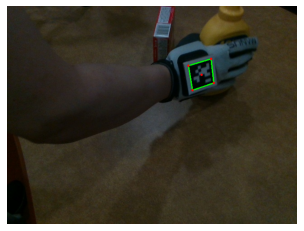

In [88]:
apriltags = AprilTags(intrinsics, xml_dir, recording="recording_wAprilTag/20210714_002709/", cameras=cameras)
apriltags.image(idx="000573", camera="020122061233")

In [81]:
apriltags.corners(idx="000573", camera="020122061233")

(None, '020122061233')

# PCD
``save_view_point`` will save the view point position when closing.

In [6]:
pcd = stiched_pcd["000557"]
world_coordinates = WorldCoordinates(pcd, cameras)

#save_view_point(pcd)
#load_view_point(pcd)

In [7]:
world_coordinates.from_camera_pixel("020122061233", u=400, v=131)

array([ 0.04416678, -0.05550768,  0.301     ])

# PCD + Corners

In [20]:
# Corner pixels
corners_p, camera = apriltags.corners(idx="000557", camera="020122061233")
# Corners world
corners_w = world_coordinates.from_corners(corners_p, camera)

In [9]:
corners_balls = get_balls_from_corners(corners_w)

vis = [pcd] + corners_balls

# load_view_point(vis)

# Save

In [13]:
save_dir = os.path.join(apriltags.recording_dir, "pcds")

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
for i in range(58, 600):
    idx = str(i).zfill(6)
    
    # Stiched point cloud from all the cameras
    pcd = stiched_pcd[idx]
    world_coordinates = WorldCoordinates(pcd)
    
    # Corner pixels
    corners_p, camera = apriltags.corners(idx=idx)
    
    # If apriltag is not found visualize only the stiched point cloud
    if corners_p is None:
        vis = pcd
    
    # If the apriltag is found, visualize the corners of the apriltag
    else:
        # Corners world
        corners_w = world_coordinates.from_corners(corners_p, camera)
        
        corners_balls = get_balls_from_corners(corners_w)
        vis = [pcd] + corners_balls
    
    
    filename = os.path.join(save_dir, f"img_{idx}.png")
    save_draw_geometries(vis, filename)

# Visible cameras

In [42]:
os.listdir(apriltags.recording_dir)

['020122061233', '020122061651', '821312060044', '821312062243', 'pcds']

In [51]:
n = 880

from collections import defaultdict

visible_cameras = defaultdict(list)

for i in range(0, n):
    idx = str(i).zfill(6)
    
    # Stiched point cloud from all the cameras
    pcd = stiched_pcd[idx]
    world_coordinates = WorldCoordinates(pcd)
    
    n_visibles = 0
    
    for camera in cameras:
        # Corner pixels
        corners_p, camera = apriltags.corners(idx=idx, camera=camera)
        
        visible = 0 if corners_p is None else 1
        visible_cameras[camera].append(visible)
        
        n_visibles += visible
    
    visible_cameras['All'].append(n_visibles)

In [80]:


non_visible_frames = [i for i, e in enumerate(visible_cameras['All']) if e == 0]
non_visible_frames

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 175,
 176,
 177,
 179,
 180,
 199,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 302,
 330,
 331,
 332,
 333,
 334,
 345,
 371,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 381,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 425,
 426,
 427,
 428,


In [77]:
1 - visible_cameras['All'].count(0) / len(visible_cameras['All'])

0.5704545454545454

<AxesSubplot:>

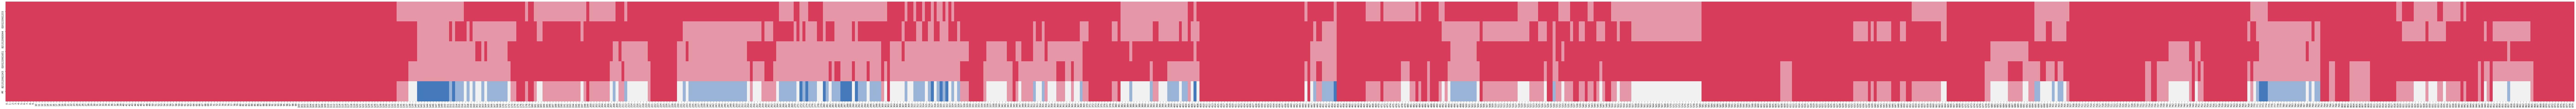

In [74]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(visible_cameras).T
cmap = sns.diverging_palette(5, 250, as_cmap=True)

fig = plt.figure(figsize=(200, 8))
ax = fig.add_subplot()

#df.style.background_gradient(cmap, axis=1)\
#    .set_properties(**{'max-width': '80px'})

sns.heatmap(df, annot=False,  
            cmap=cmap, cbar=False, ax=ax)

# Using extrinsic and intrinsic information

In [27]:
# Corner pixels
corners_p, camera = apriltags.corners(idx="000557", camera="020122061233")
# Corners world
corners_w = world_coordinates.from_corners(corners_p, camera)

idx = "000557"
depth_name = f"aligned_depth_to_color_{idx}.png"
depth_pth = os.path.join(xml_dir, "recording_wAprilTag/20210714_002709/", "020122061233", depth_name)
depth = o3d.io.read_image(depth_pth)

In [34]:
a = np.zeros((4,3))

fx, fy, cx, cy = intrinsics.params_from_camera("020122061233")

for i, corner_p in enumerate(corners_p):
    u, v = corner_p
    z = np.asarray(depth)[v,u]/1000
    
    x = (u - cx) * z / fx
    y = (v - cy) * z / fy
    
    a[i,:] = np.array([x,y,z])


In [41]:
corners_balls = get_balls_from_corners(a)
pcd = stiched_pcd["000557"]
vis = [pcd] + corners_balls

load_view_point(vis)